In [1]:
from pathlib import Path
import json

%matplotlib inline
import numpy as np
import pandas as pd
from collections import defaultdict

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torchvision.models import resnet34
from torch.utils.data.sampler import SubsetRandomSampler
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import model_utils
import plot_utils

#from custom_datasets import PascalDataset

In [2]:
JPEG_DIR = Path('dataset/')

In [3]:
pose_list = json.load(Path('pose-list-with-meta.json').open())

In [ ]:
pose_id_to_sanskrit_name = {0: 'Bharadvajasana I', 1: 'Padangusthasana', 2: 'Paripurna Navasana', 3: 'Baddha Konasana', 4: 'Dhanurasana', 5: 'Setu Bandha Sarvangasana', 6: 'Ustrasana', 7: 'Marjaryasana', 8: 'Chakravakasana', 9: 'Ashtanga Namaskara', 10: 'Utkatasana', 11: 'Balasana', 12: 'Bhujangasana', 13: 'Savasana', 14: 'Gomukhasana', 15: 'Bitilasana', 16: 'Bakasana', 17: 'Makara Adho Mukha Svanasana', 18: 'Ardha Pincha Mayurasana', 19: 'Adho Mukha Svanasana', 20: 'Garudasana', 21: 'Sukhasana', 22: 'Astavakrasana', 23: 'Utthita Hasta Padangustasana', 24: 'Uttana Shishosana', 25: 'Utthita Parsvakonasana', 26: 'Utthita Trikonasana', 27: 'Pincha Mayurasana', 28: 'Agnistambhasana', 29: 'Tittibhasana', 30: 'Matsyasana', 31: 'Chaturanga Dandasana', 32: 'Malasana', 33: 'Parighasana', 34: 'Ardha Bhekasana', 35: 'Ardha Matsyendrasana', 36: 'Supta Matsyendrasana', 37: 'Ardha Chandrasana', 38: 'Adho Mukha Vriksasana', 39: 'Ananda Balasana', 40: 'Janu Sirsasana', 41: 'Virasana', 42: 'Krounchasana', 43: 'Utthita Ashwa Sanchalanasana', 44: 'Parsvottanasana', 45: 'Viparita Karani', 46: 'Salabhasana', 47: 'Natarajasana', 48: 'Padmasana', 49: 'Anjaneyasana', 50: 'Marichyasana III', 51: 'Hanumanasana', 52: 'Tadasana', 53: 'Pasasana', 54: 'Eka Pada Rajakapotasana', 55: 'Eka Pada Rajakapotasana II', 56: 'Mayurasana', 57: 'Kapotasana', 58: 'Phalakasana', 59: 'Halasana', 60: 'Eka Pada Koundinyanasana I', 61: 'Eka Pada Koundinyanasana II', 62: 'Marichyasana I', 63: 'Supta Baddha Konasana', 64: 'Supta Padangusthasana', 65: 'Supta Virasana', 66: 'Parivrtta Janu Sirsasana', 67: 'Parivrtta Parsvakonasana', 68: 'Parivrtta Trikonasana', 69: 'Tolasana', 70: 'Paschimottanasana', 71: 'Bhujapidasana', 72: 'Parsva Bakasana', 73: 'Vasisthasana', 74: 'Anantasana', 75: 'Salamba Bhujangasana', 76: 'Dandasana', 77: 'Uttanasana', 78: 'Ardha Uttanasana', 79: 'Urdhva Prasarita Eka Padasana', 80: 'Salamba Sirsasana', 81: 'Salamba Sarvangasana', 82: 'Vriksasana', 83: 'Urdhva Dhanurasana', 84: 'Dwi Pada Viparita Dandasana', 85: 'Purvottanasana', 86: 'Urdhva Hastasana', 87: 'Urdhva Mukha Svanasana', 88: 'Virabhadrasana I', 89: 'Virabhadrasana II', 90: 'Virabhadrasana III', 91: 'Upavistha Konasana', 92: 'Prasarita Padottanasana', 93: 'Camatkarasana', 94: 'Yoganidrasana', 95: 'Vrischikasana', 96: 'Vajrasana', 97: 'Tulasana', 98: 'Simhasana', 99: 'Makarasana', 100: 'Lolasana', 101: 'Kurmasana', 102: 'Garbha Pindasana', 103: 'Durvasasana', 104: 'Bhujapidasana', 105: 'Bhekasana', 106: 'Bhairavasana', 107: 'Ganda Bherundasana'}

In [13]:
pose_name_to_id = {}
for k,v in pose_id_to_sanskrit_name.items():
    pose_name_to_id[v] = k

In [5]:
im_counts = {}
for p in JPEG_DIR.iterdir():
    if(str(p).split('/')[-1]!='.DS_Store'):
        im_counts[str(p).split('/')[-1]] = len(list(p.iterdir()))-1

In [ ]:
im_counts = {'ashtanga namaskara': 34, 'chakravakasana': 70, 'eka pada rajakapotasana ii': 55, 'anantasana': 43, 'kapotasana': 57, 'hanumanasana': 35, 'parighasana': 43, 'marichyasana i': 49, 'tittibhasana': 57, 'janu sirsasana': 48, 'yoganidrasana': 46, 'kurmasana': 40, 'ananda balasana': 59, 'krounchasana': 45, 'phalakasana': 57, 'garbha pindasana': 36, 'adho mukha svanasana': 70, 'eka pada koundinyanasana i': 51, 'vajrasana': 54, 'padmasana': 68, 'virabhadrasana i': 55, 'salamba bhujangasana': 55, 'parivrtta trikonasana': 62, 'supta virasana': 60, 'lolasana': 36, 'supta baddha konasana': 71, 'upavistha konasana': 60, 'tolasana': 60, 'simhasana': 49, 'ardha pincha mayurasana': 47, 'ardha bhekasana': 40, 'camatkarasana': 54, 'malasana': 68, 'uttanasana': 63, 'urdhva mukha svanasana': 63, 'tadasana': 56, 'durvasasana': 39, 'eka pada koundinyanasana ii': 58, 'chaturanga dandasana': 90, 'virasana': 50, 'natarajasana': 72, 'ustrasana': 87, 'baddha konasana': 70, 'bhekasana': 39, 'matsyasana': 57, 'utthita hasta padangustasana': 59, 'parsva bakasana': 56, 'marichyasana iii': 33, 'dandasana': 60, 'tulasana': 31, 'utkatasana': 73, 'purvottanasana': 63, 'sukhasana': 50, 'bhujangasana': 73, 'viparita karani': 69, 'vasisthasana': 74, 'makarasana': 57, 'bakasana': 77, 'ardha chandrasana': 52, 'astavakrasana': 72, 'gomukhasana': 72, 'bharadvajasana i': 54, 'utthita parsvakonasana': 63, 'urdhva prasarita eka padasana': 53, 'mayurasana': 51, 'adho mukha vriksasana': 59, 'anjaneyasana': 64, 'salamba sarvangasana': 67, 'agnistambhasana': 33, 'prasarita padottanasana': 66, 'utthita ashwa sanchalanasana': 38, 'dwi pada viparita dandasana': 55, 'ardha matsyendrasana': 90, 'paschimottanasana': 56, 'ganda bherundasana': 39, 'padangusthasana': 18, 'salabhasana': 58, 'virabhadrasana iii': 61, 'virabhadrasana ii': 56, 'garudasana': 78, 'setu bandha sarvangasana': 58, 'ardha uttanasana': 67, 'halasana': 66, 'pincha mayurasana': 35, 'supta padangusthasana': 62, 'urdhva hastasana': 47, 'uttana shishosana': 50, 'parivrtta janu sirsasana': 39, 'vrischikasana': 51, 'urdhva dhanurasana': 68, 'utthita trikonasana': 69, 'paripurna navasana': 68, 'bitilasana': 87, 'parivrtta parsvakonasana': 40, 'bhujapidasana': 61, 'balasana': 72, 'bhairavasana': 46, 'salamba sirsasana': 60, 'vriksasana': 62, 'eka pada rajakapotasana': 44, 'dhanurasana': 46, 'marjaryasana': 46, 'savasana': 57, 'parsvottanasana': 35, 'supta matsyendrasana': 54, 'makara adho mukha svanasana': 43, 'pasasana': 56}

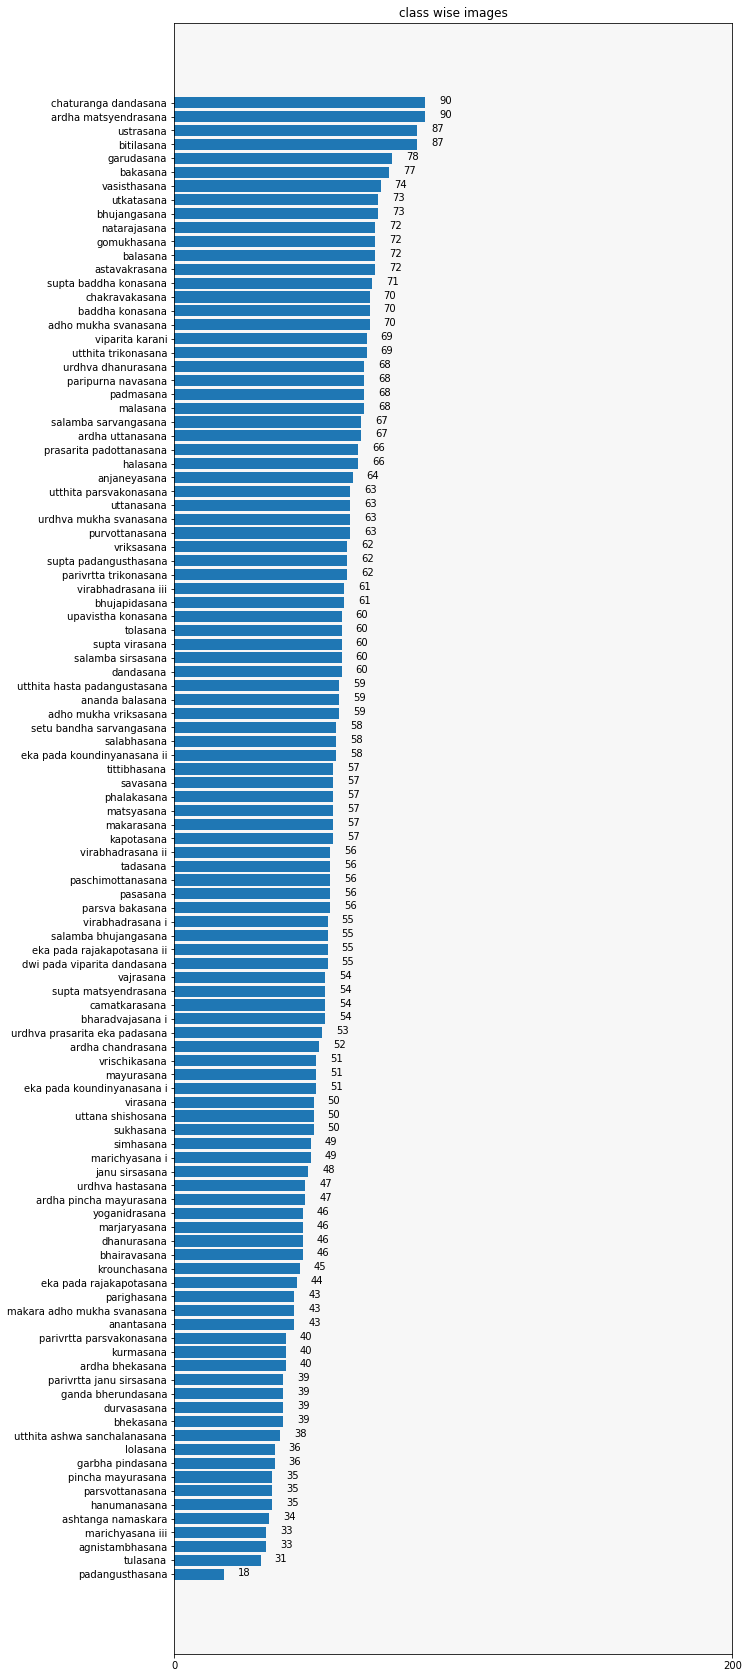

In [6]:
labels = im_counts.keys()
counts = im_counts.values()

plot_utils.plot_horizontal_bar_chart(counts, labels, title='class wise images')        

In [27]:
pose_name_to_id = {'bharadvajasana i': 0, 'padangusthasana': 1, 'paripurna navasana': 2, 'baddha konasana': 3, 'dhanurasana': 4, 'setu bandha sarvangasana': 5, 'ustrasana': 6, 'marjaryasana': 7, 'chakravakasana': 8, 'ashtanga namaskara': 9, 'utkatasana': 10, 'balasana': 11, 'bhujangasana': 12, 'savasana': 13, 'gomukhasana': 14, 'bitilasana': 15, 'bakasana': 16, 'makara adho mukha svanasana': 17, 'ardha pincha mayurasana': 18, 'adho mukha svanasana': 19, 'garudasana': 20, 'sukhasana': 21, 'astavakrasana': 22, 'utthita hasta padangustasana': 23, 'uttana shishosana': 24, 'utthita parsvakonasana': 25, 'utthita trikonasana': 26, 'pincha mayurasana': 27, 'agnistambhasana': 28, 'tittibhasana': 29, 'matsyasana': 30, 'chaturanga dandasana': 31, 'malasana': 32, 'parighasana': 33, 'ardha bhekasana': 34, 'ardha matsyendrasana': 35, 'supta matsyendrasana': 36, 'ardha chandrasana': 37, 'adho mukha vriksasana': 38, 'ananda balasana': 39, 'janu sirsasana': 40, 'virasana': 41, 'krounchasana': 42, 'utthita ashwa sanchalanasana': 43, 'parsvottanasana': 44, 'viparita karani': 45, 'salabhasana': 46, 'natarajasana': 47, 'padmasana': 48, 'anjaneyasana': 49, 'marichyasana iii': 50, 'hanumanasana': 51, 'tadasana': 52, 'pasasana': 53, 'eka pada rajakapotasana': 54, 'eka pada rajakapotasana ii': 55, 'mayurasana': 56, 'kapotasana': 57, 'phalakasana': 58, 'halasana': 59, 'eka pada koundinyanasana i': 60, 'eka pada koundinyanasana ii': 61, 'marichyasana i': 62, 'supta baddha konasana': 63, 'supta padangusthasana': 64, 'supta virasana': 65, 'parivrtta janu sirsasana': 66, 'parivrtta parsvakonasana': 67, 'parivrtta trikonasana': 68, 'tolasana': 69, 'paschimottanasana': 70, 'bhujapidasana': 104, 'parsva bakasana': 72, 'vasisthasana': 73, 'anantasana': 74, 'salamba bhujangasana': 75, 'dandasana': 76, 'uttanasana': 77, 'ardha uttanasana': 78, 'urdhva prasarita eka padasana': 79, 'salamba sirsasana': 80, 'salamba sarvangasana': 81, 'vriksasana': 82, 'urdhva dhanurasana': 83, 'dwi pada viparita dandasana': 84, 'purvottanasana': 85, 'urdhva hastasana': 86, 'urdhva mukha svanasana': 87, 'virabhadrasana i': 88, 'virabhadrasana ii': 89, 'virabhadrasana iii': 90, 'upavistha konasana': 91, 'prasarita padottanasana': 92, 'camatkarasana': 93, 'yoganidrasana': 94, 'vrischikasana': 95, 'vajrasana': 96, 'tulasana': 97, 'simhasana': 98, 'makarasana': 99, 'lolasana': 100, 'kurmasana': 101, 'garbha pindasana': 102, 'durvasasana': 103, 'bhekasana': 105, 'bhairavasana': 106, 'ganda bherundasana': 107}

{'bharadvajasana i': 0,
 'padangusthasana': 1,
 'paripurna navasana': 2,
 'baddha konasana': 3,
 'dhanurasana': 4,
 'setu bandha sarvangasana': 5,
 'ustrasana': 6,
 'marjaryasana': 7,
 'chakravakasana': 8,
 'ashtanga namaskara': 9,
 'utkatasana': 10,
 'balasana': 11,
 'bhujangasana': 12,
 'savasana': 13,
 'gomukhasana': 14,
 'bitilasana': 15,
 'bakasana': 16,
 'makara adho mukha svanasana': 17,
 'ardha pincha mayurasana': 18,
 'adho mukha svanasana': 19,
 'garudasana': 20,
 'sukhasana': 21,
 'astavakrasana': 22,
 'utthita hasta padangustasana': 23,
 'uttana shishosana': 24,
 'utthita parsvakonasana': 25,
 'utthita trikonasana': 26,
 'pincha mayurasana': 27,
 'agnistambhasana': 28,
 'tittibhasana': 29,
 'matsyasana': 30,
 'chaturanga dandasana': 31,
 'malasana': 32,
 'parighasana': 33,
 'ardha bhekasana': 34,
 'ardha matsyendrasana': 35,
 'supta matsyendrasana': 36,
 'ardha chandrasana': 37,
 'adho mukha vriksasana': 38,
 'ananda balasana': 39,
 'janu sirsasana': 40,
 'virasana': 41,
 '

In [32]:
csv_data = {'file_name':[], 'pose_id':[], 'pose_name':[]}
for p in JPEG_DIR.iterdir():
    if str(p).split('/')[-1]!='.DS_Store':
        files = list(p.glob('*.jpg'))
        files.extend(list(p.glob('*.jpeg')))
        files.extend(list(p.glob('*.png')))
        
        for im in files:
            csv_data['file_name'].append(str(im)) 
            csv_data['pose_id'].append(pose_name_to_id[str(p).split('/')[-1]])
            csv_data['pose_name'].append(str(p).split('/')[-1])

In [35]:
df = pd.DataFrame(data=csv_data)

df.to_csv('classifier_train_data.csv',index=False)

In [36]:
classifier_csv = pd.read_csv('classifier_train_data.csv')

In [38]:
pose_id_to_sanskrit_name[9]

'Ashtanga Namaskara'

In [37]:
classifier_csv

,file_name,pose_id,pose_name
0,dataset/ashtanga namaskara/10. ashtanga-namask...,9,ashtanga namaskara
1,dataset/ashtanga namaskara/9-0.png,9,ashtanga namaskara
2,dataset/ashtanga namaskara/17-0.png,9,ashtanga namaskara
3,dataset/ashtanga namaskara/28-0.png,9,ashtanga namaskara
4,dataset/ashtanga namaskara/49-0.png,9,ashtanga namaskara
5,dataset/ashtanga namaskara/35-0.png,9,ashtanga namaskara
6,dataset/ashtanga namaskara/70-0.png,9,ashtanga namaskara
7,dataset/ashtanga namaskara/11-0.png,9,ashtanga namaskara
8,dataset/ashtanga namaskara/54-0.png,9,ashtanga namaskara
9,dataset/ashtanga namaskara/56-0.png,9,ashtanga namaskara
